In [1]:
import os
from pathlib import Path
from typing import List, Optional
from collections import defaultdict


import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


# Hack the system path a little bit so we can import ..scripts.utils
from cs285.scripts import utils

/home/jeffrey/srn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jeffrey/srn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jeffrey/srn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jeffrey/srn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWa

In [2]:
OUTPUT_DIR = Path("../output")
DATA_DIR = Path("../data")

# Helper functions

In [8]:
# Path functions
def get_subdirs(d: Path) -> List[Path]:
    return [f for f in d.iterdir() if f.is_dir()]

def get_exp_paths(exp_name: str, *, most_recent=False) -> List[Path]:
    paths = DATA_DIR.glob(f"*{exp_name}*")
    paths = list(sorted(paths, key=os.path.getmtime, reverse=True))
    paths = [p for p in paths if 'bl' not in str(p)]
    #print(paths)
    #print(exp_name)
    if most_recent:
        return [paths[0]]
    return paths

In [4]:
# Log functions

# https://github.com/franklinfrank/285project/blob/diff_ac/cs285/infrastructure/rl_trainer.py#L278-L301
def parse_tf_eventsfile(filename: str, *, tag='Eval_AverageReturn') -> List:
    eval_returns = []
    for e in tf.train.summary_iterator(filename):
        for v in e.summary.value:
            if v.tag == tag:
                eval_returns.append(v.simple_value)

    return eval_returns

# Plotting Code

In [5]:
DEFAULT_FIGSIZE = (10,8)

TEXT_SIZE_SML = 12
TEXT_SIZE_MED = 18
TEXT_SIZE_LRG = 25

FREE_VARIABLES = {
    'env_sweep': 'env_name', 
    'sample_sweep': 'sample_strategy',
    'terminal_val_sweep': 'terminal_val',
    'batch_size_sweep': 'batch_size'
}

PRETTY_TITLES = {
    'env_sweep': 'Comparison of methods on {env_name}', 
    'sample_sweep': 'Different sample strategies on {env_name}',
    'terminal_val_sweep': 'Different terminal values on {env_name}',
    'batch_size_sweep': 'Different batch size on {env_name}'
}

# BASELINES[env_name][seed]
BASELINES = {
    'CartPole-v0': {
        2020: 'ac_bl_seed=2020_env_name=CartPole-v0_sample_strategy=ordered_random_terminal_val=2_batch_size=4000_CartPole-v0_16-12-2019_13-56-50',
        285: 'ac_bl_seed=285_env_name=CartPole-v0_sample_strategy=ordered_random_terminal_val=2_batch_size=4000_CartPole-v0_16-12-2019_13-56-50',
        2: 'ac_bl_seed=2_env_name=CartPole-v0_sample_strategy=ordered_random_terminal_val=2_batch_size=4000_CartPole-v0_16-12-2019_13-56-50'
        
    },
    'HalfCheetah-v2': {
        2020: 'ac_bl_seed=2020_env_name=HalfCheetah-v2_sample_strategy=ordered_random_terminal_val=2_batch_size=4000_HalfCheetah-v2_16-12-2019_13-56-50',
        285: 'ac_bl_seed=285_env_name=HalfCheetah-v2_sample_strategy=ordered_random_terminal_val=2_batch_size=4000_HalfCheetah-v2_16-12-2019_13-56-49',
        2: 'ac_bl_seed=2_env_name=HalfCheetah-v2_sample_strategy=ordered_random_terminal_val=2_batch_size=4000_HalfCheetah-v2_16-12-2019_13-56-50'
    },
    'InvertedPendulum-v2': {
        2020: 'ac_bl_seed=2020_env_name=InvertedPendulum-v2_sample_strategy=ordered_random_terminal_val=2_batch_size=4000_InvertedPendulum-v2_16-12-2019_13-56-50',
        285: 'ac_bl_seed=285_env_name=InvertedPendulum-v2_sample_strategy=ordered_random_terminal_val=2_batch_size=4000_InvertedPendulum-v2_16-12-2019_13-56-50',
        2: 'ac_bl_seed=2_env_name=InvertedPendulum-v2_sample_strategy=ordered_random_terminal_val=2_batch_size=4000_InvertedPendulum-v2_16-12-2019_13-56-50'
    }
}

In [22]:
def plot_exp_set(exp_set_name: str, *, plot_baseline=False) -> None:
    """ Always averages over seeds
    """ 
    
    # Create a figure for each environment
    for i, env_name in enumerate(utils.environments):
        title = PRETTY_TITLES[exp_set_name].format(env_name=env_name)
        plt.figure(i, figsize=DEFAULT_FIGSIZE)
        plt.title(title)
    
    logfiles = defaultdict(lambda: defaultdict(list))
    tmp = utils.get_exp_flags(exp_set_name)
    for exp_flags in tmp:
        # Get the run_folder for this combination of experiment flags
        exp_name = utils.get_exp_name(exp_flags)
        #print(exp_name)
        run_folder = get_exp_paths(exp_name, most_recent=True)[0]
        # Identify the logfile
        logfile = str(list(run_folder.iterdir())[0])
        
        # Average over seed, so get a exp_name that excludes the seed
        exp_label = exp_flags[FREE_VARIABLES[exp_set_name]] if exp_set_name is not "env_sweep" else "Differential"
        logfiles[exp_flags['env_name']][exp_label].append(logfile)
    
    ys_to_plot = []
    # Average over seed
    for env_name, trials in logfiles.items():
        for label, files in trials.items():
            # Aggregate things
            trial_ys = []
            for logfile in files:
                trial_ys.append(parse_tf_eventsfile(logfile))
            trial_ys = np.array(trial_ys)
            
            y_min = np.min(trial_ys, axis=0)
            y_avg = np.average(trial_ys, axis=0)
            y_max = np.max(trial_ys, axis=0)
            print(trial_ys.shape[1])
            stderr = np.std(trial_ys, axis=0, ddof=1) / np.sqrt(trial_ys.shape[1])
            print(stderr)
            y_lower = y_avg - stderr
            y_upper = y_avg + stderr
            xs = range(y_avg.shape[0])
            
            # Get the correct figure
            plt.figure(utils.environments.index(env_name))
            plt.plot(y_avg, label=label)
            plt.fill_between(xs, y_lower, y_upper, alpha=.2)
            #plt.fill_between(xs, y_lower, y_upper, alpha=.2)
            
            # Plot baselines
            if plot_baseline:
                bl_ys = []
                for seed, log_folder in BASELINES[env_name].items():
                    log_folder = DATA_DIR / log_folder
                    logfile = str(list(log_folder.iterdir())[0])
                    bl_ys.append(parse_tf_eventsfile(logfile))
                bl_ys = np.array(bl_ys)
                
                bl_ys_min = np.min(bl_ys, axis=0)
                bl_ys_avg = np.average(bl_ys, axis=0)
                bl_ys_max = np.max(bl_ys, axis=0)
                print(bl_ys.shape[1])
                bl_stderr = np.std(bl_ys, axis=0, ddof=1) / np.sqrt(bl_ys.shape[1])
                print(bl_stderr)
                #print(env_name, bl_std)
                bl_y_lower = bl_ys_avg - bl_stderr
                bl_y_upper = bl_ys_avg + bl_stderr
                xs = range(bl_ys_avg.shape[0])
                
                plt.plot(bl_ys_avg, label='Baseline')
                plt.fill_between(xs, bl_y_lower, bl_y_upper, alpha=.2)
            
            plt.legend()
            
    for i, env_name in enumerate(utils.environments):
        plt.figure(i)
        title = f"{exp_set_name}__on__{env_name}"
        plt.savefig(OUTPUT_DIR / title)
    
    plt.show()

[0.11662857 2.1322053  0.7109378  1.15642611 1.43786803 0.83395416
 0.71447644 1.9722571  1.09473043 0.54702046 0.21962571 0.1241572
 0.96299769 0.21360201 1.01552919 0.86653379 0.39687346 0.75515038
 0.76562494 0.43968553 0.17277957 0.48671369 0.86882767 0.50147195
 0.52513164 1.10333306 0.89092901 1.74931379 0.79152744 1.61496509
 0.6759272  1.55424504 0.28923805 0.43541466 0.61538064 0.35624553
 0.25221542 0.06709698 0.390037   0.71892573 0.98208784 0.60757264
 0.85106927 1.00530154 0.65553079 0.99417162 0.89857932 1.39528576
 1.41545881 0.46639088 0.24447825 1.24651075 0.89996742 1.63099729
 1.77455811 1.60441641 1.17225513 1.16223741 2.25283007 1.25019625
 1.36938965 1.92359059 0.48853941 0.80856968 0.99974327 1.62873531
 0.77131422 1.35903241 0.29085564 0.96179466 0.76516224 0.27345763
 0.45564645 1.32763129 1.79376576 0.38203463 0.3396063  0.93448991
 1.31299869 0.84849738 1.74851798 0.52131485 0.45359962 0.60434059
 1.41237083 3.45668276 3.04897294 3.61673227 3.1507262  2.11474

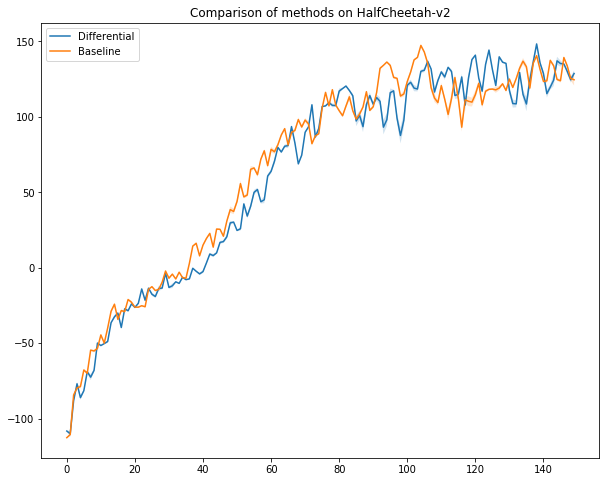

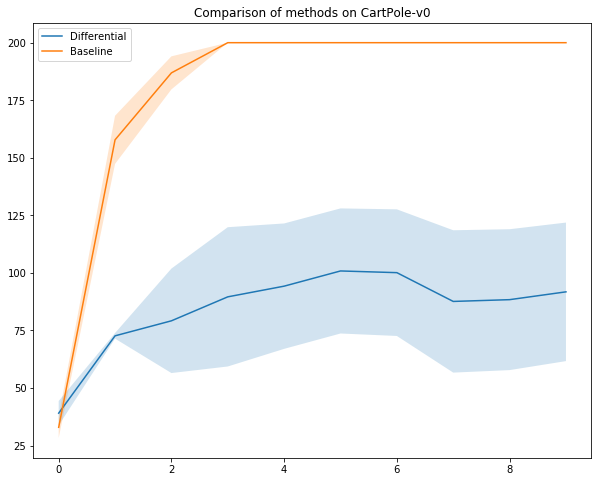

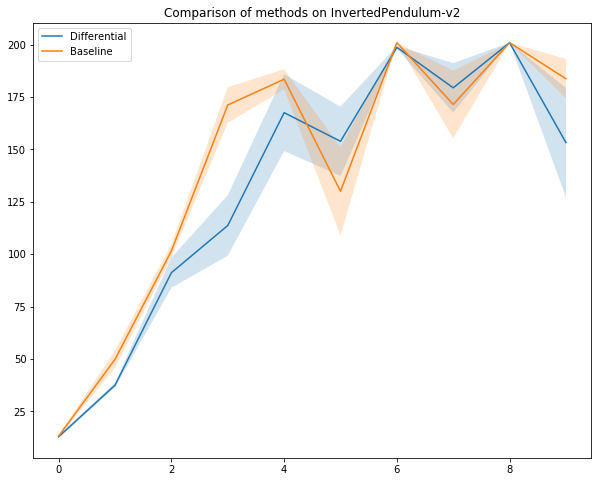

[0.11662857 2.1322053  0.7109378  1.15642611 1.43786803 0.83395416
 0.71447644 1.9722571  1.09473043 0.54702046 0.21962571 0.1241572
 0.96299769 0.21360201 1.01552919 0.86653379 0.39687346 0.75515038
 0.76562494 0.43968553 0.17277957 0.48671369 0.86882767 0.50147195
 0.52513164 1.10333306 0.89092901 1.74931379 0.79152744 1.61496509
 0.6759272  1.55424504 0.28923805 0.43541466 0.61538064 0.35624553
 0.25221542 0.06709698 0.390037   0.71892573 0.98208784 0.60757264
 0.85106927 1.00530154 0.65553079 0.99417162 0.89857932 1.39528576
 1.41545881 0.46639088 0.24447825 1.24651075 0.89996742 1.63099729
 1.77455811 1.60441641 1.17225513 1.16223741 2.25283007 1.25019625
 1.36938965 1.92359059 0.48853941 0.80856968 0.99974327 1.62873531
 0.77131422 1.35903241 0.29085564 0.96179466 0.76516224 0.27345763
 0.45564645 1.32763129 1.79376576 0.38203463 0.3396063  0.93448991
 1.31299869 0.84849738 1.74851798 0.52131485 0.45359962 0.60434059
 1.41237083 3.45668276 3.04897294 3.61673227 3.1507262  2.11474

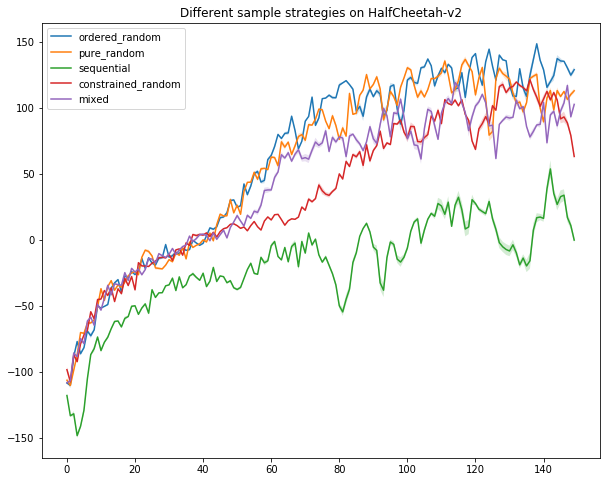

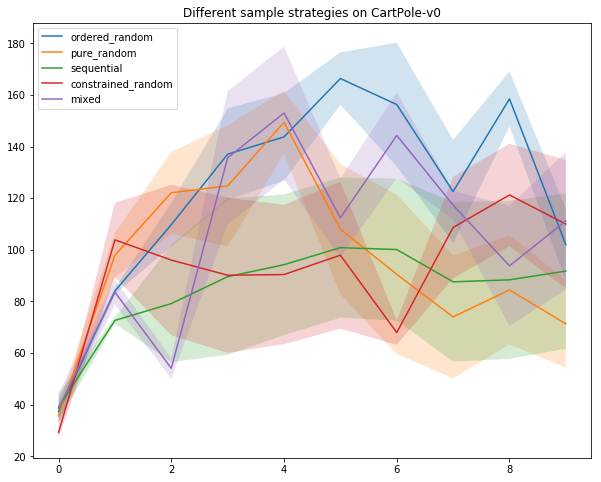

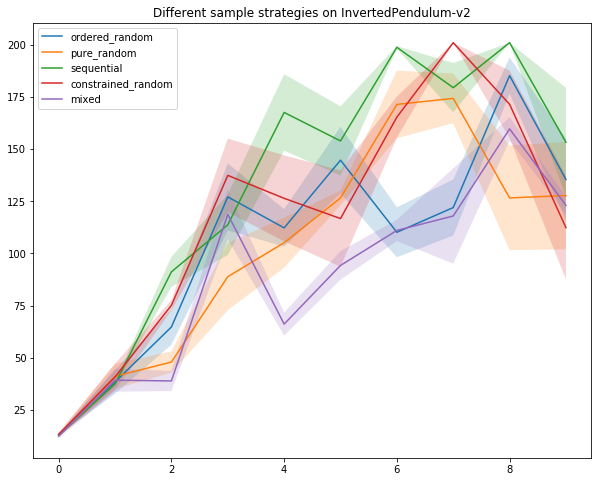

[1.46591058 0.60158492 1.05320398 1.03643544 0.37487054 1.51712482
 0.98626016 0.9446436  0.62809294 1.02648942 0.6308496  0.49663419
 0.72198394 0.44841442 1.02910777 0.11841879 0.73833142 0.67053012
 0.27295513 0.2503954  0.3764414  0.75610317 0.53918474 0.80088595
 1.28374963 0.97421972 0.81135873 0.85649364 0.7358353  0.60729726
 0.7569332  0.48117291 0.34296529 0.35405789 0.48386771 0.15804689
 0.42944223 0.5601699  0.10851453 0.58133391 0.22018623 0.68562746
 0.91845355 0.662107   0.59203948 0.75173217 0.59542814 0.80404134
 1.3979038  2.13763543 0.88057887 1.61230733 1.60456052 0.36005824
 0.11510272 1.83457305 0.24643881 1.53506738 1.74260348 1.33233423
 1.44084628 1.48367024 0.70360722 0.95978443 0.48632681 1.82756815
 0.431058   0.65056236 0.83034895 1.05154314 0.70160859 1.2552542
 0.58553451 0.57315684 0.99008147 1.43794283 1.44761189 0.79684032
 0.17374199 0.93200618 1.45753043 1.63728872 2.38325191 5.36407758
 4.54867737 3.37471108 1.85287501 1.83287042 3.18777251 4.00018

[1.4643314  0.95948182 0.94624119 0.22911809 0.99133026 0.86012914
 1.78360294 0.83942379 0.81850273 0.44218114 1.90569802 0.5516035
 0.80059857 0.74157807 0.65609302 1.04398419 1.23885482 0.97245745
 0.58734103 0.47066917 0.45416686 0.79006988 1.13848139 0.57277103
 1.28031372 1.27516655 0.89227663 0.34200175 0.29487507 1.44754629
 0.83408981 2.47734005 0.777053   1.99892453 1.66348326 0.8925862
 0.77248967 0.81218108 1.51428814 2.68646088 1.10026765 0.57704466
 1.08791868 1.9213769  1.95641221 1.71572261 1.18527001 3.26163789
 1.54601359 1.80302636 1.46266356 3.00273417 2.39655047 2.90496678
 1.38246078 1.39611009 2.27076324 1.97204737 2.13449998 1.27789552
 1.21404162 2.36443457 1.52384227 1.94131273 0.34902265 0.49483015
 0.52508609 1.26031455 1.01357275 0.82787961 0.84431779 1.18765956
 0.65452376 0.8932635  0.73961103 1.39344809 2.61816665 1.44626642
 0.96356272 1.24893748 2.05699763 3.41151685 2.38202957 0.77394175
 1.21822135 0.8616945  1.35675694 1.1457229  3.38801474 3.841215

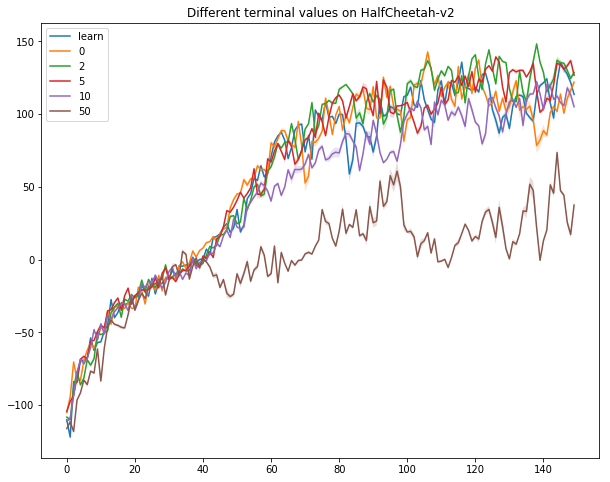

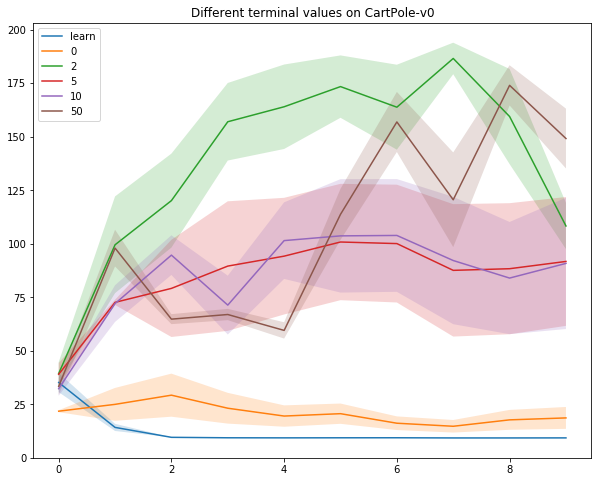

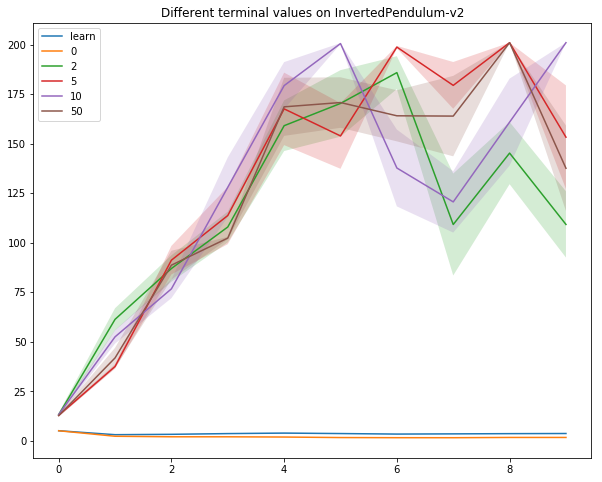

[1.60087842 0.83138983 1.1997815  0.94997472 1.06009229 0.81289188
 0.66738063 0.81152573 0.31651759 0.31899198 0.55226369 0.9445914
 0.51290168 0.26437976 0.25256792 0.92129617 0.79302134 0.99614598
 0.06500412 0.62241881 0.29449064 0.78525347 0.45220677 0.45689214
 0.46747246 0.69820512 0.74565926 0.36396008 0.1833026  0.82149056
 0.84645013 0.110135   0.2075464  0.15190552 0.58100089 0.16001356
 0.37032541 1.04046478 0.74152178 0.17548461 0.75142825 0.34378981
 0.46865275 0.48309176 0.65984217 0.72154992 1.15757052 1.29324943
 1.75571329 1.86370484 1.98979675 1.25374222 1.4883752  2.50492354
 1.97895952 2.03335044 1.46491916 1.24010185 2.62000272 1.11666775
 1.49441508 3.34283465 2.82281299 1.73430019 1.65949663 1.73275647
 1.4954547  2.48284699 2.65504392 3.56331133 4.03088542 3.27617486
 2.26110473 3.06177528 2.03419544 1.15875547 1.81890253 1.53152849
 1.51258334 1.4487798  2.49580965 2.47514486 2.77817737 1.91916452
 1.75855829 1.94738871 2.26673265 2.22407326 2.0506022  2.98272

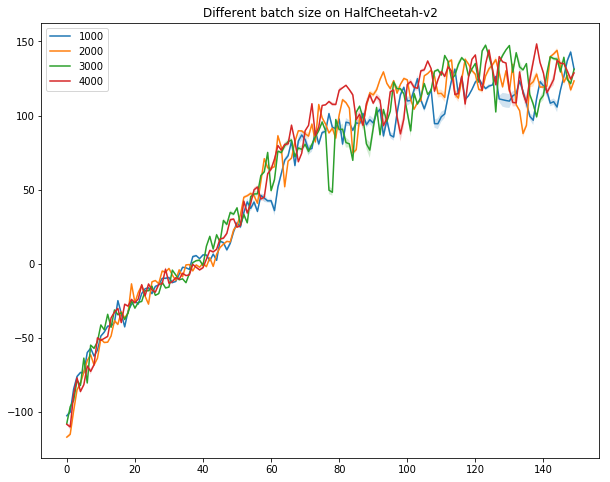

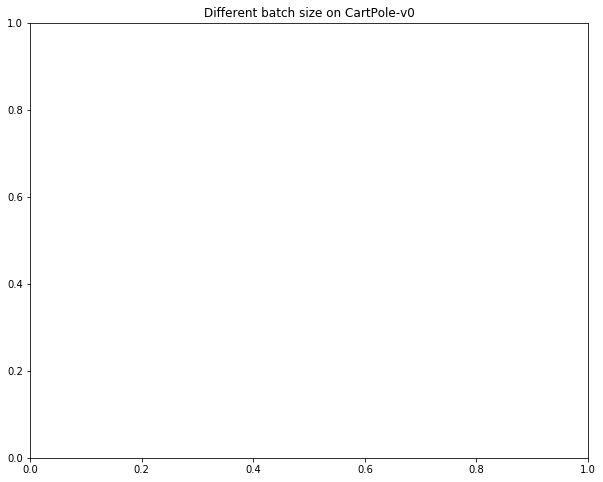

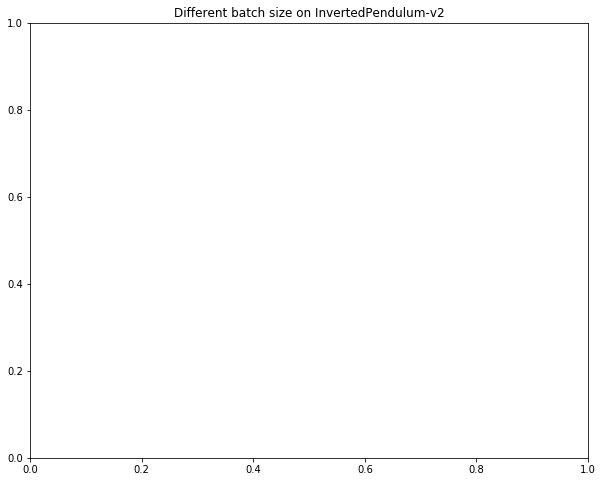

In [21]:
plot_exp_set('env_sweep', plot_baseline=True)
plot_exp_set('sample_sweep')
plot_exp_set('terminal_val_sweep')
plot_exp_set('batch_size_sweep')